# Coursework: Hydraulic model calibration


### CIVE 70019/70057
Department of Civil and Environmental Engineering, Imperial College London

You have been tasked with the evaluation and calibration of the hydraulic model of EXNING, a district metered area (DMA) in Anglian Water's (AW) water distribution network. To achieve this, you have been provided:
* a recently calibrated hydraulic model of the EXNING DMA (2019),
* loading conditions (demands, reservoir heads) and head measurements covering a period of 4 days.

The objective of the coursework is to prepare a short calibration report for AW by completing the tasks below and answering the questions based on your results.

You have been provided the following information about EXNING:
* EXNING is part of a larger system of cascading DMAs: EXNING is fed by the NEWSEV DMA and feeds into the BURWEL DMA.
* The "reservoir" head and total demand of EXNING are derived from flow and pressure sensors at the DMA inlet (& outlet).
* Node elevations have been updated in the provided model following a GPS survey of sensor locations.

In [2]:
import sys
import os
import numpy as np
from numpy import linalg as la
import networkx as nx
import pandas as pd
import wntr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import copy
from datetime import datetime, timedelta
import cvxpy as cp
## TODO
import warnings
warnings.filterwarnings('ignore')

# improve matplotlib image quality
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

### Load network properties and operational data

Load functions created in previous assignments.

In [3]:
# load functions from src folder
sys.path.append('../src/')
from general_functions import *
from hydraulic_functions import *

Load network .inp file and operational data from the module repository's data directory.

In [4]:
data_dir = '../data/parameter_estimation/'
net_dir = '../data/networks/'

net_name = 'exning.inp'
data_name = 'exning_coursework_dataset.npy'

# load operational data
data = np.load(os.path.join(data_dir, data_name), allow_pickle=True).item()
h_data = data['h_data']
sensor_idx = data['sensor_idx'] - 1 # matlab to python index offset
d_data = data['d']
h0_data = data['h0'].reshape(-1, 1).T

# load network properties
wdn = load_network_data(os.path.join(net_dir, net_name))
A12 = wdn.A12
A10 = wdn.A10
net_info = wdn.net_info
link_df = wdn.link_df
node_df = wdn.node_df
demand_df = wdn.demand_df

Plot sensor nodes in network. We provide a plotting function below.

In [5]:
#### DO NOT CHANGE THIS ####
# define plotting function using networkx
def plot_network(wdn, sensor_idx, vals=None, highlight_valves=None):

    # create figure and axis
    fig, ax = plt.subplots(figsize=(10, 7))

    # unload data
    link_df = wdn.link_df
    node_df = wdn.node_df
    net_info = wdn.net_info

    # draw network
    uG = nx.from_pandas_edgelist(link_df, source='node_out', target='node_in')
    pos = {row['node_ID']: (row['xcoord'], row['ycoord']) for _, row in node_df.iterrows()}
    nx.draw(uG, pos, ax=ax, node_size=20, node_shape='o')

    # draw reservoir
    nx.draw_networkx_nodes(
        uG, pos, nodelist=net_info['reservoir_names'],
        node_size=100, node_shape='s', node_color='black', ax=ax
    )

    # draw sensor nodes
    sensor_names = [net_info['junction_names'][i] for i in sensor_idx]
    nx.draw_networkx_nodes(
        uG, pos, nodelist=sensor_names, node_size=100,
        node_shape='o', node_color='red', edgecolors='white', ax=ax
    )

    # reservoir labels
    reservoir_labels = {node: 'Reservoir' for node in net_info['reservoir_names']}
    labels_res = nx.draw_networkx_labels(uG, pos, reservoir_labels, font_size=12, ax=ax)
    for _, label in labels_res.items():
        label.set_y(label.get_position()[1] + 1750)

    # sensor labels
    sensor_labels = {node: str(idx+1) for (idx, node) in enumerate(sensor_names)}
    labels_sen = nx.draw_networkx_labels(uG, pos, sensor_labels, font_size=12, ax=ax)
    for _, label in labels_sen.items():
        label.set_y(label.get_position()[1] + 1750)

    # plot sensor values if provided
    if vals is not None:
        cmap = cm.get_cmap('RdYlGn_r')
        nx.draw_networkx_nodes(
            uG, pos, nodelist=sensor_names, node_size=100,
            node_shape='o', node_color=vals, cmap=cmap, edgecolors='white', ax=ax
        )

        # create color bar
        sm = plt.cm.ScalarMappable(cmap=cmap)
        sm.set_array(vals)
        colorbar = plt.colorbar(sm, ax=ax)
        colorbar.set_label('Mean pressure residual [m]', fontsize=12)

    # highlight link
    if highlight_valves is not None:
        nx.draw_networkx_nodes(uG, pos, highlight_valves, node_size=200, node_shape='d', node_color='limegreen', edgecolors='white')

    # display plot
    plt.show()

Visualise the EXNING network graph and highlight information relevant to the evaluation of the hydraulic model.

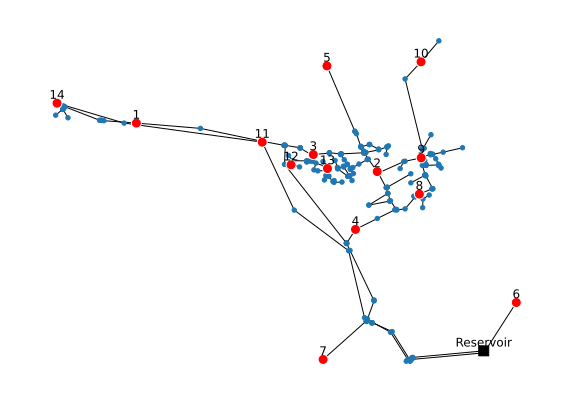

In [6]:
plot_network(wdn, sensor_idx)

Simulate initial (uncalibrated) network hydraulics over 4 days. We first define a function to solve network hydraulics using the `wntr` package, which we used previously in the hyraulic modelling notebook. The following tasks are performed in this function:
- Load network properties
- Modify simulation time to match operational data
- Assign h0 data at model reservoir
- Scale and apply new demand pattern from inflow data
- Option to modify pipe roughness (or HW) coefficients

<font color="blue">NB: this is done for you below. Provided the correct inputs, you do not need to replicate this function.

In [7]:
#### DO NOT CHANGE THIS ####
# hydraulic solver function
def hydraulic_solver(inp_file, d_data, h0_data, C=None, demand=False):

    # load network from wntr
    inp_file = os.path.join(net_dir, net_name)
    wn = wntr.network.WaterNetworkModel(inp_file)

    # get network properties
    reservoir_names = wn.reservoir_name_list
    junction_names = wn.junction_name_list
    link_names = wn.link_name_list

    # modify simulation time and hydraulic time step
    nt = h0_data.shape[1]
    wn.options.time.duration = (nt - 1) * 3600
    wn.options.time.hydraulic_timestep = 3600
    wn.options.time.pattern_timestep = 3600
    wn.options.time.report_timestep = 3600

    # assign reservoir data
    for (i, name) in enumerate(reservoir_names):
        wn.add_pattern(f'h0_{i}', h0_data[i])
        reservoir = wn.get_node(name)
        reservoir.head_timeseries.base_value = 1
        reservoir.head_timeseries.pattern_name = wn.get_pattern(f'h0_{i}')

    # replace demand data
    for idx, name in enumerate(junction_names):

        if any(val != 0 for val in d_data[idx, :]):
            node = wn.get_node(name)
            d_pat = d_data[idx, :]
            wn.add_pattern('d_'+name, d_pat)

            for (i, num) in enumerate(node.demand_timeseries_list):
                if i == 0:
                    node.demand_timeseries_list[i].base_value = 1
                    node.demand_timeseries_list[i].pattern_name = 'd_'+name
                else:
                    node.demand_timeseries_list[i].base_value = None
                    node.demand_timeseries_list[i].pattern_name = None

    # assign roughness (or HW) coefficients
    if C is not None:
        for name, link in wn.links():

            # check if the link is a pipe
            if isinstance(link, wntr.network.Pipe):
                link.roughness = C[link_names.index(name)]

            # check if link is a valve
            elif isinstance(link, wntr.network.Valve):
                link.minor_loss = C[link_names.index(name)]
                link.initial_setting = C[link_names.index(name)]

    # run simulation and get results
    sim = wntr.sim.EpanetSimulator(wn)
    results = sim.run_sim()

    q_sim = results.link['flowrate'].T
    h_sim = results.node['head'].T
    h_sim = h_sim[~h_sim.index.isin(reservoir_names)] # delete reservoir nodes
    d = results.node['demand'].T
    d = d[~d.index.isin(reservoir_names)] # delete reservoir nodes


    if demand == True:
        return d.to_numpy()
    else:
        return q_sim.to_numpy(), h_sim.to_numpy()

### Part 0: Preliminary evaluation

Run simulation with initial $C_0$ values.

In [8]:
C_0 = link_df['C'].to_numpy()
# Supplants the network model with the available data (loading conditions, head measurements).
q_sim, h_sim = hydraulic_solver("", d_data, h0_data, C_0)

Compare simulated heads at sensor nodes (node indices in `sensor_idx`) with the simulated heads over the 4-day period. Visualise the results with, e.g. a boxplot of pressure residuals on the test dataset.

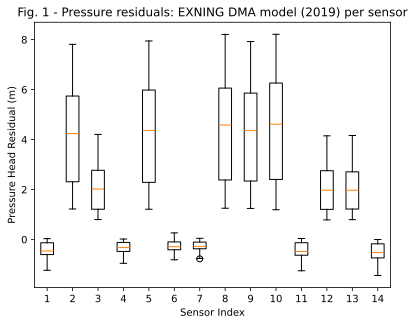

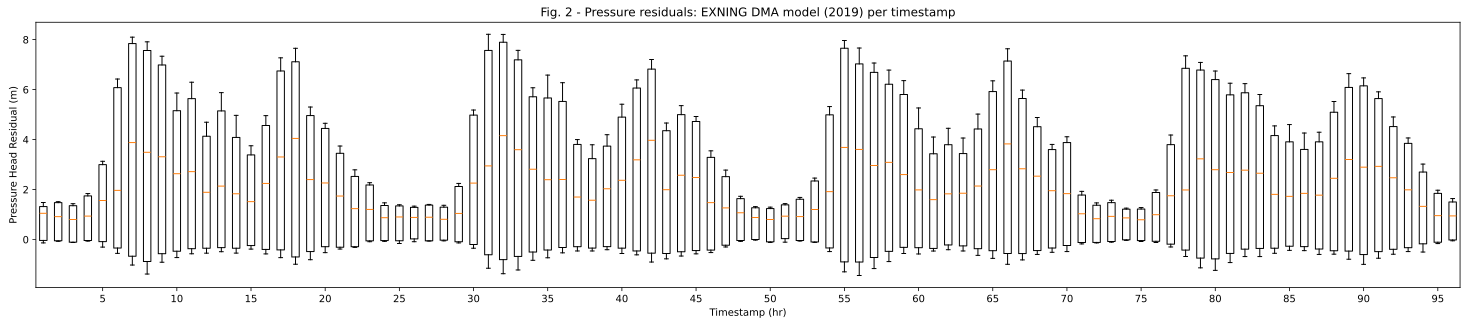

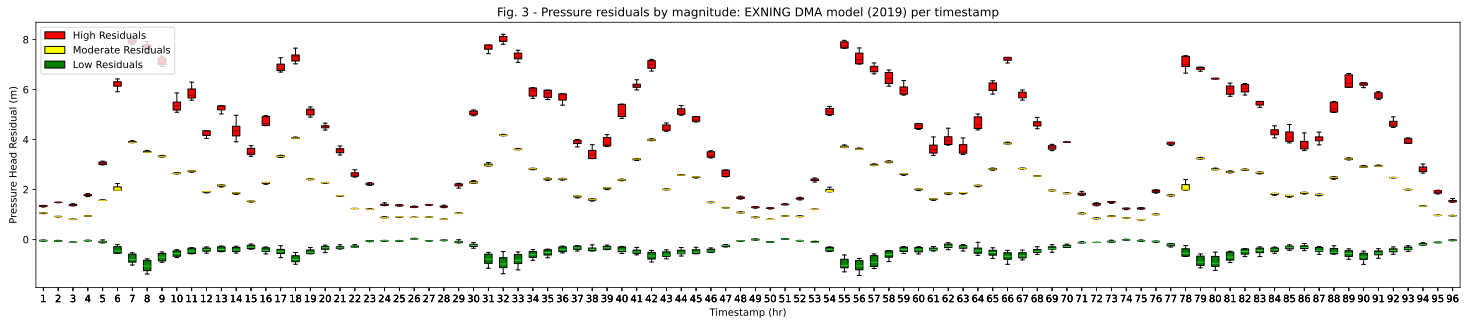

In [9]:
# from Lecture 3 - Assignment Review: `Pressure residual = simulated - measured``

sensor_idx_residuals = np.zeros(h_data.shape)
for (data_idx, sim_idx) in enumerate(sensor_idx):
    sensor_idx_residual = np.array(h_sim[sim_idx] - h_data[data_idx])
    sensor_idx_residuals[data_idx] = sensor_idx_residual

plt.boxplot(sensor_idx_residuals.tolist())
plt.xlabel("Sensor Index")
plt.ylabel("Pressure Head Residual (m)")
plt.title("Fig. 1 - Pressure residuals: EXNING DMA model (2019) per sensor")
plt.show()

timestamp_residuals = sensor_idx_residuals.T

# Widened figure size and filtered timestamps help readibility.
default_figsize = plt.rcParams['figure.figsize']
widened_figsize = [default_figsize[0]*4, default_figsize[1]]
plt.subplots(figsize = widened_figsize)
plt.boxplot(timestamp_residuals.tolist())
plt.xlabel("Timestamp (hr)")

ticks, labels = plt.xticks()
filtered_labels = []
filtered_ticks = []
for i in range(0, ticks.size):
    # Boxplots are 1-indexed.
    if i % 5 == 4:
        filtered_labels.append(labels[i])
        filtered_ticks.append(ticks[i])
plt.xticks(filtered_ticks, filtered_labels)

plt.ylabel("Pressure Head Residual (m)")
plt.title("Fig. 2 - Pressure residuals: EXNING DMA model (2019) per timestamp")

plt.show()

# Per plot, there's a clear grouping of sensors with high, moderate and low residuals.
high_res_idx = {2, 5, 8, 9, 10}
moderate_res_idx = {3, 12, 13}
low_res_idx = {1, 4, 6, 7, 11, 14}

# Boxplot labels are 1-indexed; convert to 0-index to correspond to data.
def zero_index(one_indexed_list):
    zero_indexed_list = {i-1 for i in one_indexed_list}
    return zero_indexed_list

high_res_idx = zero_index(high_res_idx)
moderate_res_idx = zero_index(moderate_res_idx)
low_res_idx = zero_index(low_res_idx)

assert high_res_idx & moderate_res_idx & low_res_idx == set()
assert high_res_idx | moderate_res_idx | low_res_idx == set(range(0, sensor_idx.size))

high_timestamp_residuals = timestamp_residuals[:, list(high_res_idx)]
moderate_timestamp_residuals = timestamp_residuals[:, list(moderate_res_idx)]
low_timestamp_residuals = timestamp_residuals[:, list(low_res_idx)]

# Widened figure size helps readibility.
plt.subplots(figsize = widened_figsize)

high_result = plt.boxplot(high_timestamp_residuals.tolist(), label='High Residuals', sym='', patch_artist=True)
moderate_result = plt.boxplot(moderate_timestamp_residuals.tolist(), label='Moderate Residuals', sym='', patch_artist=True)
low_result = plt.boxplot(low_timestamp_residuals.tolist(), label='Low Residuals', sym='', patch_artist=True)

for i in range(0, timestamp_residuals.shape[0]):
    high_result['boxes'][i].set_facecolor('red')
    high_result['medians'][i].set_color('darkred')

    moderate_result['boxes'][i].set_facecolor('yellow')
    moderate_result['medians'][i].set_color('gold')

    low_result['boxes'][i].set_facecolor('green')
    low_result['medians'][i].set_color('limegreen')

plt.xlabel("Timestamp (hr)")
plt.ylabel("Pressure Head Residual (m)")
plt.title("Fig. 3 - Pressure residuals by magnitude: EXNING DMA model (2019) per timestamp")

plt.legend(loc = 'upper left')
plt.show()

**<u>Question 1:</u>** Is the current hydraulic model of EXNING accurate according to hydraulic model calibration guidelines? Comment on the results of the preliminary model evaluation and, in particular, on
* the **sign** (i.e. are heads over or underestimated in the hydraulic simulation?) of pressure/head residuals,
* the **temporal** distribution (i.e. are the residuals time/flow dependent?) of pressure/head residuals,
* and the **spatial** distribution (i.e. are all sensors affected?) of the pressure/head residuals.

Given the information you were provided about the EXNING system and the results of the preliminary model evaluation, identify the most likely sources of model errors.

The majority of the estimates of the current model are beyond 2m accepted threshold from the measured value; far more than 5%. This fails the _Water Network Modelling Standard_ guidelines (this is especially obvious in Fig. 2).

As visualized in Fig. 1, there's a clear partition between `high`, `moderate` and `low` residual sensors:
* As can be inferred from these labels, the `high` group is severely overestimated by the simulation and the `moderate` group heads are somewhat overestimated. Interestingly, the `low` group heads are slightly underestimated.
* We see the residual magnitudes follow a diurnal pattern: in the morning and evening all the magnitudes increase (`high` and `moderate` groups rise postively and `low` decreases below 0). See Fig. 3.
* The `moderate` and `high` groups are clustered together spatially.

Given the residuals are localized rather than uniformally distributed we expect we need to adjust the valve local loss coefficient. This be because a valve was incorrectly recorded as opened or closed in the field.

### Part 1: Hydraulic model calibration (without regularisation)

Following initial reports concerning discrepancies in the recently calibrated EXNING model, AW were able to confirm that:
- flow and head sensors had been calibrated before collection of load/field data corresponding to the train and test datasets,
- demands in the train and test dataset are accurate (incl. for large users).

As a result, the remaining deviations between measured and simulated pressures must result from inaccurate model parameters. Errors associated with unknown valve status (for instance, unregistered closed valves) can be identified by solving a model calibration problem where pipe roughness coefficients are known, but valve minor/local loss coefficients are free to vary. In part 1, you will solve a hydraulic model calibration problem without regularisation. Complete the code below to calibrate the network model using the head measurements provided in data.

#### Split the data into *train* and *test* datasets.
We suggest using the first day worth of data as a <u>train dataset</u> and the remaining 3 days as a <u>test dataset</u>.

In [10]:
# train data
nt_train = 24
data_train = {
    'd': d_data[:, :nt_train],
    'h0': h0_data[:, :nt_train],
    'h_data': h_data[:, :nt_train]
}

# test data
data_test = {
    'd': d_data[:, nt_train:],
    'h0': h0_data[:, nt_train:],
    'h_data': h_data[:, nt_train:]
}

**<u>Question 2:</u>** Briefly comment on the definition of the train data set. What impact will it have on the generalizability of your model? (i.e., what range of conditions will you confidently be able to use your model for?)

We are training the model with the first day's worth of collected data. If this falls on a weekend or holiday, our model will likely only be able to predict hydraulic states for weekends or holidays. Same sort of limitation if our training set data is a weekday. In general, our model won't be able to predict hydraulic states for the full week.

#### Definition of the loss function.

In [11]:
def loss_fun(h, h_data):
    return ( 1/len(h_data.flatten()) ) * np.sum( ( h[sensor_idx, :] - h_data )**2 )

**<u>Question 3:</u>** Justify the choice/definition of the loss function, loss_fun.

This loss function is mean squared error (MSE). It's really effective for callibrating models as it punishes large errors (by squaring) but has a more of a tolerance for larger errors in larger data sets by averaging (unlike LSE). It's also convex which means it satisfies one requirement for solving with CVX.

#### Solve the parameter estimation problem using the train dataset
We first solve the hydraulic model calibration problem without regularisation. (You can reuse and adapt the code provided in Week 6.)

The following function is needed for the sequential convex programming (SCP) method used in this coursework. As with the `hydraulic_solver` function, we provide the following code in `linear_approx_calibration` for you to use throughout this notebook.

In [12]:
#### DO NOT CHANGE THIS ####
# compute matrices for the head loss linear approximation of the HW headloss
def linear_approx_calibration(wdn, q, C):
    # unload data
    A12 = wdn.A12
    A10 = wdn.A10
    net_info = wdn.net_info
    link_df = wdn.link_df

    K = np.zeros((net_info['np'], 1))
    n_exp = link_df['n_exp'].astype(float).to_numpy().reshape(-1, 1)
    b1_k = copy.copy(K)
    b2_k = copy.copy(K)

    for idx, row in link_df.iterrows():
        if row['link_type'] == 'pipe':
            K[idx] = 10.67 * row['length'] * (C[idx] ** -row['n_exp']) * (row['diameter'] ** -4.8704)
            b1_k[idx] = copy.copy(K[idx])
            b2_k[idx] = (-n_exp[idx] * K[idx]) / C[idx]

        elif row['link_type'] == 'valve':
            K[idx] = (8 / (np.pi ** 2 * 9.81)) * (row['diameter'] ** -4) * C[idx]
            b1_k[idx] = -n_exp[idx] * copy.copy(K[idx])
            b2_k[idx] = copy.copy(K[idx]) / C[idx]

    a11_k = np.tile(K, q.shape[1]) * np.abs(q) ** (n_exp - 1)
    b1_k = np.tile(b1_k, q.shape[1]) * np.abs(q) ** (n_exp - 1)
    b2_k = np.tile(b2_k, q.shape[1]) * np.abs(q) ** (n_exp - 1) * q

    return a11_k, b1_k, b2_k

SCP implementation

In [20]:
# unload network training data
n_exp = link_df['n_exp']
d = data_train['d']
h_data = data_train['h_data']
h0 = data_train['h0'].reshape(-1, 1).T

# define SCP problem parameters
Ki = np.inf
iter_max = 50
delta_k = 20
# Per lecture 6, you may use values of 1000 or 10000 to simulate a closed valve
C_up_valve = 10000
C_lo_valve = 0.2

# initialise values
theta_k = C_0 # we're trying to opitimize valves and this includes valves
q_k, h_k = hydraulic_solver("", d, h0, C=C_0)
a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, C_0)
objval_k = loss_fun(h_k, h_data)

print("Part 0 MSE (previously calibrated): {objval_k}") # TODO: MG - is this the right way to log?

### main scp code ###
for k in range(iter_max):

    # decision variables
    q = cp.Variable((net_info['np'], nt_train))
    h = cp.Variable((net_info['nn'], nt_train))
    theta = cp.Variable(net_info['np'])

    # objective function (defined using CVXPY functions)
    loss = ( 1/len(h_data.flatten()) ) * cp.sum_squares( h[sensor_idx,:] - h_data )
    objective = cp.Minimize(loss)

    # hydraulic feasibility constraints
    constraints = []
    # MG: A11(q)q is head loss matrix
    # MG: A12(h) and A10(h0) track which nodes are in this head loss relationship
    # MG: A21T is mass conversvation
    # MG: I think theta_min and theta_max provide bounds in which the problem must end
    for t in range(nt_train):
        # energy and mass constraints
        # MG: i think the first term are the same size.
        constraints += [
            cp.multiply(b1_k[:, t], q_k[:, t]) + cp.multiply(cp.multiply(n_exp, a11_k[:, t]), q[:, t]) + cp.multiply(b2_k[:, t], theta) + A12 @ h[:, t] + A10 @ h0[:, t] == 0,
            A12.T @ q[:, t] == d[:, t]
        ]

    # trust region constraints
    constraints += [
        cp.norm(theta - theta_k, 'inf') <= delta_k
    ]

    # pipe HW coefficient constraints
    pipe_constraints = [theta[idx] == C_0[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
    constraints += pipe_constraints

    # variable bounds to solve for valve
    lower_bound_valve = [theta[idx] >= C_lo_valve for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
    constraints += lower_bound_valve
    upper_bound_valve = [theta[idx] <= C_up_valve for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
    constraints += upper_bound_valve

    # solve optimisation problem
    problem = cp.Problem(objective, constraints)
    cvx_val = problem.solve(solver=cp.ECOS, verbose=False, abstol=1e-3)

    # store optimal solution and compute actual and predicted decrease in objval
    theta_tilde = theta.value
    [q_tilde, h_tilde] = hydraulic_solver(os.path.join(net_dir, net_name), d, h0, C=theta_tilde)
    objval_tilde = loss_fun(h_tilde, h_data)

    predicted_decrease = objval_k - cvx_val # based on a linear approximation
    actual_decrease = objval_k - objval_tilde

    # evaluate latest SCP iteration
    if actual_decrease / predicted_decrease >= 0.1:
        objval_old = objval_k
        theta_k = theta_tilde
        q_k = q_tilde
        h_k = h_tilde
        objval_k = objval_tilde
        a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
        Ki = np.abs(objval_old - objval_k) / np.abs(objval_old)
        delta_k = 1.1 * delta_k
        print(f"Iteration {k} successful! Update estimate and increase trust region size. \n")

    else:
        delta_k = 0.25 * delta_k
        print(f"Iteration {k} unsuccessful! Return to previous estimate and reduce trust region size. \n")

    print(f"{k} {objval_k} {Ki} {delta_k} \n")

    # MG: if objective function isn't changing significantly or error is very small or trust region update is very small.
    # MG: did i do something wrong? i only have 18 iterations and my obj value is very low.
    if Ki <= 1e-3 or np.abs(objval_k) <= 1e-2 or delta_k <= 1e-1:
        break


Part 0 MSE (previously calibrated): {objval_k}
Iteration 0 successful! Update estimate and increase trust region size. 

0 5.262606241561236 0.45776722595036595 22.0 

Iteration 1 successful! Update estimate and increase trust region size. 

1 2.6570331483247815 0.49511078230764033 24.200000000000003 

Iteration 2 successful! Update estimate and increase trust region size. 

2 1.7427506517012985 0.34409901780861263 26.620000000000005 

Iteration 3 successful! Update estimate and increase trust region size. 

3 1.4215035184452478 0.18433338868210697 29.282000000000007 

Iteration 4 successful! Update estimate and increase trust region size. 

4 1.236754993169475 0.12996698416746744 32.21020000000001 

Iteration 5 successful! Update estimate and increase trust region size. 

5 1.0681718329385432 0.13631087900352667 35.43122000000001 

Iteration 6 successful! Update estimate and increase trust region size. 

6 0.9035933677442579 0.15407489705240549 38.974342000000014 

Iteration 7 success

**<u>Question 4:</u>** Describe the nature/role of the different outputs of the SCP algorithm printed above (objvalk, Ki, Deltak) and explain their trends.

**`objval_k`:** The current value of the loss function, i.e. MSE. We can see it decreases when the iteration are successful and stays the same when they are unsuccesful. This makes sense as we only accept the estimate if the actual loss reduction is a sufficient portion of the linear approx. loss reduction from CVX.(?)
MG: TODO

Store the solution (i.e. new coefficients `theta_k`) as $C_1$.

In [21]:
C_1 = theta_k

Evaluate final model error and visualise head residuals corresponding to *test* dataset.

Part 1 MSE (without regularization): {mse_test_1}


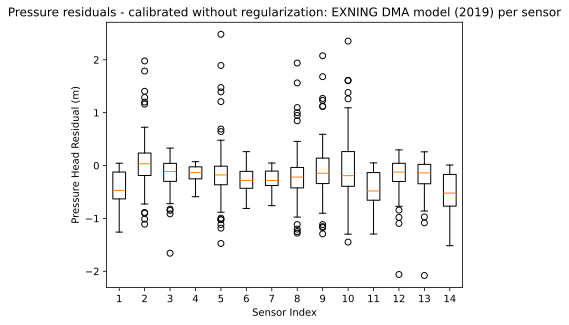

In [22]:
_, h_test = hydraulic_solver("", data_test['d'], data_test['h0'], C=C_1)
mse_test_1 = loss_fun(h_test, data_test['h_data'])

print("Part 1 MSE (without regularization): {mse_test_1}") # TODO: MG - is this the right way to log?

sensor_idx_residuals_1 = h_test[sensor_idx,:] - data_test['h_data']
plt.boxplot(sensor_idx_residuals_1.tolist())
plt.xlabel("Sensor Index")
plt.ylabel("Pressure Head Residual (m)")
plt.title("Pressure residuals - calibrated without regularization: EXNING DMA model (2019) per sensor") # TODO: MG title
plt.show()

**<u>Question 5:</u>** Comment on the improvement in model accuracy (before vs. after calibration).

- less of a clear spatial distinction between group of high, medium and low residuals.
- visually, it looks like it may meet the Thames guidelines.
- could add spatial residuals plot for clarity.
TODO: MG

#### Discuss the values of the calibrated coefficients $C_1$
Visualise the values of newly calibrated coefficients $C_1$ compared to original model coefficients C.

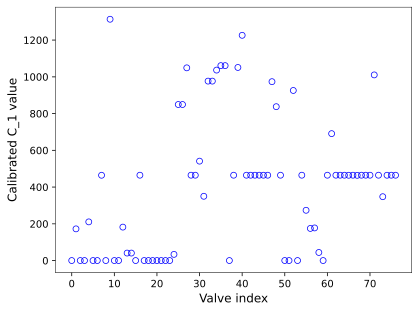

In [64]:
# C_1 value scatter plot (valves only)
valve_C0 = [C_0[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
valve_C1 = [C_1[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
fig, ax = plt.subplots()
ax.scatter(range(len(valve_C1)), valve_C1, facecolors='none', edgecolors='b',linewidths=0.75)
ax.set_xlabel('Valve index', fontsize=12)
ax.set_ylabel('Calibrated C_1 value', fontsize=12)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

# TODO: MG think of different way to visualize since valves were all 0.2.
# Maybe a line on 0.2; vs. index

**<u>Question 6:</u>** Comment on the values of parameter estimates in and explain the results of the calibration without regularisation.

- many of the estimates suggest partially open valves which we wouldn't expect in practice; we'd expect almost all valves to be fully open or fully closed.


TODO: MG

### Part 2: Hydraulic model calibration (with regularisation)

In order to reduce the underdeterminedness of the hydraulic model calibration problem (and improve the accuracy of the calibrated model), regularisation can be applied to incorporate prior knowledge about the expected variance or sparsity pattern of parameters $\theta$. Use the code provided in Weeks 5 and 6, and modify as necessary below to calibrate the hydraulic model with regularisation, using the same train data as before.

#### Definition of the regularisation function
Ridge regression (l2-regularisation) shrinks parameter estimates (without actually driving them to 0) in the hopes of reducing variance and improving prediction accuracy while lasso regression (-regularisation) encourages sparsity, driving many parameter estimates exactly to zero.

**<u>Question 7:</u>** Based on your answer to Question 6, comment on the expected variance or sparsity pattern of $\theta$. What type of regularisation (ridge or lasso) term should be included in the objective function of the model calibration problem?

Lasso: we want to drive estimates to 0.

TODO: MG - what is `sparsity` in this context?

The loss function is defined as:

In [94]:
def reg_fun(h, h_data, C, l):
    # quick prototype
    normalized_valve_C = [C[idx] - 0.2 for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
    print(normalized_valve_C)
    return np.sum( ( h[sensor_idx, :] - h_data )**2 ) + l*np.linalg.norm(normalized_valve_C, ord=1)
    # i also removed the error average part. 


#### Solve the parameter estimation problem using the train dataset
Solve the hydraulic model calibration problem with regularisation.

In [122]:
# lambda_opts = [10**-6, 10**-4, 10**-2]
lambda_opts = [10**-2] # TODO: MG redo
for l in lambda_opts:

    # unload network training data
    n_exp = link_df['n_exp']
    d = data_train['d']
    h_data = data_train['h_data']
    h0 = data_train['h0'].reshape(-1, 1).T

    # define SCP problem parameters
    Ki = np.inf
    iter_max = 50
    delta_k = 100
    # Per lecture 6, you may use values of 1000 or 10000 to simulate a closed valve
    C_up_valve = 1000
    C_lo_valve = 0.2

    # initialise values
    theta_k = C_0 # we're trying to opitimize valves and this includes valves
    q_k, h_k = hydraulic_solver("", d, h0, C=C_0)
    a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, C_0)
    objval_k = reg_fun(h_k, h_data, theta_k, l)

    for k in range(iter_max):

        # decision variables
        q = cp.Variable((net_info['np'], nt_train))
        h = cp.Variable((net_info['nn'], nt_train))
        theta = cp.Variable(net_info['np'])

        # objective function (defined using CVXPY functions)
        normalized_valve = cp.vstack([theta[idx] - 0.2 for idx, row in link_df.iterrows() if row['link_type'] == 'valve'])
        loss = cp.sum( ( h[sensor_idx, :] - h_data )**2 ) + l*cp.norm(normalized_valve, 1)
        objective = cp.Minimize(loss)

        # hydraulic feasibility constraints
        constraints = []
        # MG: A11(q)q is head loss matrix
        # MG: A12(h) and A10(h0) track which nodes are in this head loss relationship
        # MG: A21T is mass conversvation
        # MG: I think theta_min and theta_max provide bounds in which the problem must end
        for t in range(nt_train):
            # energy and mass constraints
            # MG: i think the first term are the same size.
            constraints += [
                cp.multiply(b1_k[:, t], q_k[:, t]) + cp.multiply(cp.multiply(n_exp, a11_k[:, t]), q[:, t]) + cp.multiply(b2_k[:, t], theta) + A12 @ h[:, t] + A10 @ h0[:, t] == 0,
                A12.T @ q[:, t] == d[:, t]
            ]

        # trust region constraints
        constraints += [
            cp.norm(theta - theta_k, 'inf') <= delta_k
        ]

        # pipe HW coefficient constraints
        pipe_constraints = [theta[idx] == C_0[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
        constraints += pipe_constraints

        # variable bounds to solve for valve
        lower_bound_valve = [theta[idx] >= C_lo_valve for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
        constraints += lower_bound_valve
        upper_bound_valve = [theta[idx] <= C_up_valve for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
        constraints += upper_bound_valve

        # solve optimisation problem
        problem = cp.Problem(objective, constraints)
        cvx_val = problem.solve(solver=cp.ECOS, verbose=False, abstol=1e-3) # TODO: MG fix verbose

        # store optimal solution and compute actual and predicted decrease in objval
        theta_tilde = theta.value
        [q_tilde, h_tilde] = hydraulic_solver(os.path.join(net_dir, net_name), d, h0, C=theta_tilde)
        objval_tilde = reg_fun(h_tilde, h_data, theta_tilde, l)

        predicted_decrease = objval_k - cvx_val # based on a linear approximation
        actual_decrease = objval_k - objval_tilde

        # evaluate latest SCP iteration
        if actual_decrease / predicted_decrease >= 0.1:
            objval_old = objval_k
            theta_k = theta_tilde
            q_k = q_tilde
            h_k = h_tilde
            objval_k = objval_tilde
            a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
            Ki = np.abs(objval_old - objval_k) / np.abs(objval_old)
            delta_k = 1.1 * delta_k
            print(f"Iteration {k} successful! Update estimate and increase trust region size. \n")

        else:
            delta_k = 0.5 * delta_k
            print(f"Iteration {k} unsuccessful! Return to previous estimate and reduce trust region size. \n")

        print(f"{k} {objval_k} {Ki} {delta_k} {l} \n")

        # MG: if objective function isn't changing significantly or error is very small or trust region update is very small.
        # MG: did i do something wrong? i only have 18 iterations and my obj value is very low.
        if Ki <= 1e-3 or np.abs(objval_k) <= 1e-2 or delta_k <= 1e-1:
            break

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[7.10066185988234e-07, 2.4031630356802225e-05, 1.1830358892517268e-07, 1.5261343890293766e-06, 2.1632356818984677e-05, 2.22960589262855e-05, 1.983758488799392e-05, 2.183631000579611e-05, 5.4296405667397796e-06, 2.6541730897805538e-05, 99.99999924371963, 3.0665261993578774e-07, 99.99999950139133, 63.792018131668236, 64.3500772931851, 99.99999497523063, 2.1836310125034064e-05, 3.3700167023642535e-06, 3.3700167975381223e-06, 1.1882439456545324e-06, 5.4296404589648795e-06, 62.107784686625266, 61.21639072695279, 1.0858331371543795e-06, 8.434783346056296e-06, 2.524296568257034e-05, 2.524296577885443e-05, 99.99998

Store the solution (i.e. new coefficients `theta_k`) as $C_2$.

In [123]:
C_2 = theta_k

Evaluate final model error and visualise head residuals corresponding to *test* dataset.

[1.4552228414510537e-06, 5.813054770006931e-05, 2.5942735604189693e-07, 3.5905434128402636e-06, 5.785132612121102e-05, 2.332206887051269e-05, 4.2034923523726064e-05, 5.842617457316179e-05, 1.2720320648945682e-05, 8.332828826621008e-05, 7.8323995731914815, 2.091387985181381e-06, 606.9987023812718, 7.935551959997733e-05, 7.935576513315445e-05, 45.70723120527596, 5.842617656584559e-05, 7.302776684897649e-06, 7.3027777369449876e-06, 1.8382030738395283e-06, 1.2720319098213917e-05, 3.135659470743235e-06, 3.1356588651720863e-06, 1.5212007094728142e-05, 4.20651068755995e-05, 5.877789252337062e-05, 5.877789346672713e-05, 6.511752474872012e-05, 5.842617610812839e-05, 5.842617673451622e-05, 112.34936909652716, 5.737530117030931e-05, 5.9061931846654536e-05, 5.906193234478385e-05, 6.427402800460169e-05, 7.396399098125173e-05, 7.396398417919281e-05, 4.726657734790973e-05, 5.84261767045402e-05, 6.146836575957049e-05, 815.8499075118355, 5.842617647827675e-05, 5.84261760720739e-05, 5.842617574153275e-0

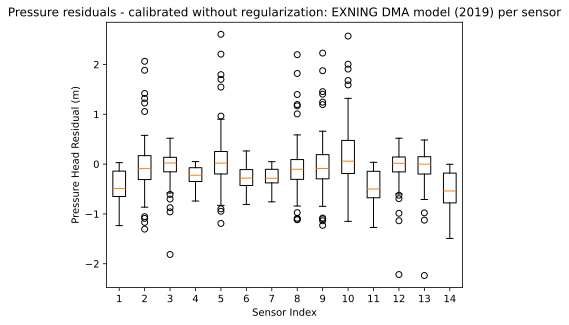

In [125]:
_, h_test = hydraulic_solver("", data_test['d'], data_test['h0'], C=C_2)
error_test_2 = reg_fun(h_test, data_test['h_data'], C_2, 10**-2) #MG: TODO change

print("Part 2 Error (without regularization): {error_test_2}") # TODO: MG - is this the right way to log?

sensor_idx_residuals_2 = h_test[sensor_idx,:] - data_test['h_data']
plt.boxplot(sensor_idx_residuals_2.tolist())
plt.xlabel("Sensor Index")
plt.ylabel("Pressure Head Residual (m)")
plt.title("Pressure residuals - calibrated without regularization: EXNING DMA model (2019) per sensor") # TODO: MG title
plt.show()

**<u>Question 8:</u>** Comment on the improvement in model accuracy after calibration with regularisation.

#### Discuss the values of the calibrated coefficients $C_2$
Visualise the values of newly calibrated coefficients $C_2$.

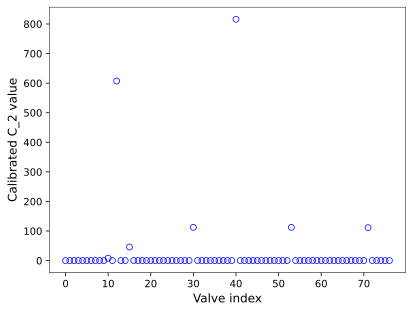

In [ ]:
# C_2 value scatter plot (valves only)
valve_C2 = [C_2[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
fig, ax = plt.subplots()
ax.scatter(range(len(valve_C2)), valve_C2, facecolors='none', edgecolors='b',linewidths=0.75)
ax.set_xlabel('Valve index', fontsize=12)
ax.set_ylabel('Calibrated C_2 value', fontsize=12)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

# TODO: MG think of different way to visualize since valves were all 0.2.
# Maybe a line on 0.2; vs. index

**<u>Question 9:</u>** Comment on the values of parameter estimates in $C_2$ compared to $C_1$ and explain the results of the calibration with regularisation.

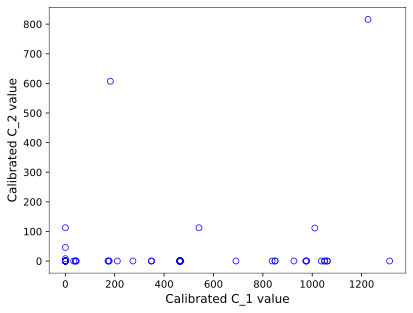

In [127]:
# C_1 value scatter plot (valves only)
valve_C1 = [C_1[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
valve_C2 = [C_2[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
fig, ax = plt.subplots()
ax.scatter(valve_C1, valve_C2, facecolors='none', edgecolors='b',linewidths=0.75)
ax.set_xlabel('Calibrated C_1 value', fontsize=12)
ax.set_ylabel('Calibrated C_2 value', fontsize=12)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

# TODO: MG think of different way to visualize since valves were all 0.2.
# Maybe a line on 0.2; vs. index

**<u>Question 10:</u>** Do the calibrated local loss coefficient values in $C_2$ corroborate the conclusions of the preliminary analysis about the most likely sources of error in the EXNING model (existence/location of unknowingly closed valves)? Summarise your findings (100-150 words + 1-2 figures) and provide recommendations to AW to validate your proposed hydraulic model update.
